# MODEL

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam


import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import timeit
import copy
from torch.utils.data import Dataset, DataLoader
import time
import copy
import math
import os
#from pytorchtools import EarlyStopping

In [3]:
DATASET_PATH = '/disk1/data/fashion/'

class MyDataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None ):
    
    self.df = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transforms = transforms
    
  def __getitem__(self,idx):
    d = self.df.iloc[idx]
    image = Image.open(self.img_dir+'/'+d[0]).convert("RGB")
    label = torch.tensor(d[1:].tolist() , dtype=torch.float32)
    
    if self.transforms is not None:
      image = self.transforms(image)
    return image,label
  
  def __len__(self):
    return len(self.df)

    

In [4]:
from torch.utils.data import random_split
batch_size=32
transform = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
Path = os.path.join(DATASET_PATH, 'resized')
dataset = MyDataset("/disk1/data/fashion/_id_.csv" , Path , transform)
valid_no = int(len(dataset)*0.12) 
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])

#trainset , rest_idx = train_test_split(np.arange(len(dataset)), test_size= 0.4, random_state=42, shuffle=True, stratify = le3)
#valset, testset  = train_test_split( np.arange(len(rest_idx)), test_size= 0.5, random_state=42, shuffle=True) 

print(f"trainset len: {len(trainset)}, valset len: {len(valset)}")

dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

trainset len: 36879, valset len: 5028


In [19]:
DF = pd.read_csv("/disk1/data/fashion/_id_.csv")
DF = DF.iloc[:,1:]
DF.head()
DF = DF.to_numpy()
DF.shape

(41907, 141)

In [ ]:
#print(dataset.__getitem__(0))
#print(dataset.__getitem__(1))
#print(MyDataset.__getitem__(dataset,0))
print(len(dataset))
print(dataset.df)

In [4]:
model = models.mobilenet_v2(pretrained=True) # load the pretrained model

## freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)

In [7]:



import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=141).to(device)
print(model)

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [8]:
from tqdm import trange
from sklearn.metrics import precision_score,f1_score, multilabel_confusion_matrix

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):
    since = time.time()
  
    for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
        
        if phase=="train":     # put the model in training mode
            model.train()
            scheduler.step()
        else:     # put the model in validation mode
            model.eval()

        # keep track of training and validation loss
        running_loss = 0.0
        running_corrects = 0.0  

        for data , target in data_loader[phase]:
        #load the data and target to respective device
            data , target = data.to(device)  , target.to(device)

            with torch.set_grad_enabled(phase=="train"):
                
                #feed the input
                output = model(data)
                #calculate the loss
                loss = criterion(output,target)
                preds = torch.sigmoid(output).data > 0.5
                preds = preds.to(torch.float32)

                if phase=="train"  :
                    
                    # backward pass: compute gradient of the loss with respect to model parameters 
                    loss.backward()
                    # update the model parameters
                    optimizer.step()
                    # zero the grad to stop it from accumulating
                    optimizer.zero_grad()


                # statistics
                running_loss += loss.item() * data.size(0)
                running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)


        epoch_loss = running_loss / len(data_loader[phase].dataset)
        epoch_acc = running_corrects / len(data_loader[phase].dataset)

        result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        print(result)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
train(model,dataloader , criterion, optimizer,sgdr_partial,num_epochs=2)

Epochs:  50%|█████     | 1/2 [02:21<02:21, 141.70s/it]

['train Loss: 0.0241 Acc: 0.7865', 'val Loss: 0.0156 Acc: 0.8617']


Epochs: 100%|██████████| 2/2 [04:46<00:00, 143.17s/it]

['train Loss: 0.0169 Acc: 0.8473', 'val Loss: 0.0157 Acc: 0.8745']


In [ ]:
image , label = next(iter(dataloader["val"]))
image = image.to(device)
label = label.to(device)
output = 0
with torch.no_grad():
  output = model(image)
  output = torch.sigmoid(output)
  prob = output

     
output = output>0.2


In [13]:
print(output.shape)
print(prob.shape)
pred = output[1].tolist()
print(output[1].shape)
classes =  np.array(classLabels)[np.array(pred,dtype=np.bool)]
print(len(classLabels))
print(classes.shape)

for i , s in enumerate(classes):
    print(i, s) 

torch.Size([32, 141])
torch.Size([32, 141])
torch.Size([141])
141
(3,)
0 Accessories
1 Watches
2 Watches


In [11]:
lst = prob[1].tolist()
Myclasses =  np.array(lst)[np.array(pred)]
print(Myclasses.shape)
#text = f"{pi:.2f}"
#formatted_pi = float(text)
for i , s in enumerate(Myclasses):
    form_s = float(f"{s:.4f}")
    print(i, form_s) 

(3,)
0 0.9974
1 0.7823
2 0.8084


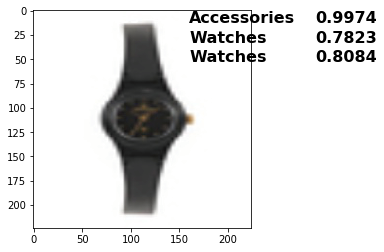

In [14]:
classLabels =['Accessories', 'Apparel', 'Footwear', 'Sporting Goods',
              'Accessories', 'Apparel Set', 'Bags', 'Belts', 'Bottomwear',
       'Cufflinks', 'Dress', 'Eyewear', 'Flip Flops', 'Gloves',
       'Headwear', 'Innerwear', 'Jewellery', 'Loungewear and Nightwear',
       'Mufflers', 'Sandal', 'Saree', 'Scarves', 'Shoe Accessories',
       'Shoes', 'Socks', 'Sports Accessories', 'Sports Equipment',
       'Stoles', 'Ties', 'Topwear', 'Umbrellas', 'Wallets', 'Watches',
       'Water Bottle', 'Wristbands','Accessory Gift Set', 'Baby Dolls', 'Backpacks', 'Bangle',
       'Basketballs', 'Bath Robe', 'Belts', 'Blazers', 'Booties',
       'Boxers', 'Bra', 'Bracelet', 'Briefs', 'Camisoles', 'Capris',
       'Caps', 'Casual Shoes', 'Churidar', 'Clothing Set', 'Clutches',
       'Cufflinks', 'Dresses', 'Duffel Bag', 'Dupatta', 'Earrings',
       'Flats', 'Flip Flops', 'Footballs', 'Formal Shoes', 'Gloves',
       'Handbags', 'Hat', 'Headband', 'Heels', 'Innerwear Vests',
       'Jackets', 'Jeans', 'Jeggings', 'Jewellery Set', 'Jumpsuit',
       'Key chain', 'Kurta Sets', 'Kurtas', 'Kurtis', 'Laptop Bag',
       'Leggings', 'Lehenga Choli', 'Lounge Pants', 'Lounge Shorts',
       'Lounge Tshirts', 'Messenger Bag', 'Mobile Pouch', 'Mufflers',
       'Necklace and Chains', 'Nehru Jackets', 'Night suits',
       'Nightdress', 'Patiala', 'Pendant', 'Rain Jacket', 'Rain Trousers',
       'Ring', 'Robe', 'Rompers', 'Rucksacks', 'Salwar',
       'Salwar and Dupatta', 'Sandals', 'Sarees', 'Scarves', 'Shapewear',
       'Shirts', 'Shoe Accessories', 'Shorts', 'Shrug', 'Skirts', 'Socks',
       'Sports Sandals', 'Sports Shoes', 'Stockings', 'Stoles',
       'Sunglasses', 'Suspenders', 'Sweaters', 'Sweatshirts', 'Swimwear',
       'Tablet Sleeve', 'Ties', 'Ties and Cufflinks', 'Tights', 'Tops',
       'Track Pants', 'Tracksuits', 'Travel Accessory', 'Trolley Bag',
       'Trousers', 'Trunk', 'Tshirts', 'Tunics', 'Umbrellas',
       'Waist Pouch', 'Waistcoat', 'Wallets', 'Watches', 'Water Bottle',
       'Wristbands']

mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
  image = image.to("cpu").clone().detach()
  image = transforms.Normalize(-mean/std,1/std)(image)                                  #denormalize
  image = image.permute(1,2,0) 
  image = torch.clamp(image,0,1)
  return image.numpy()

def visualize(image , actual , pred, prob):
  fig,ax = plt.subplots()
  ax.imshow(denormalize(image))
  ax.grid(False)
  classes =  np.array(classLabels)[np.array(actual,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
  
  classes =  np.array(classLabels)[np.array(pred,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(160 , i*20  , s , verticalalignment='top', color="black", fontsize=16, weight='bold')
    
  classes =  np.array(prob)[np.array(pred)]
  for i , s in enumerate(classes):
    form_s = float(f"{s:.4f}")    
    ax.text(290 , i*20  , form_s , verticalalignment='top', color="black", fontsize=16, weight='bold')
    

  plt.show()

visualize(image[1] , label[1].tolist() , output[1].tolist(), prob[1].tolist())

In [15]:
len(classLabels)

141

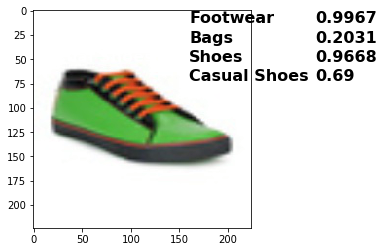

In [16]:
visualize(image[2] , label[2].tolist() , output[2].tolist(),prob[2].tolist())

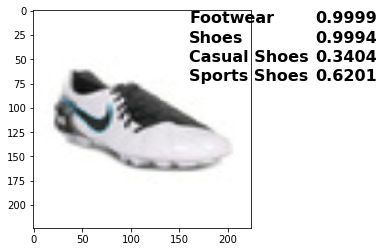

In [20]:
visualize(image[31] , label[31].tolist() , output[31].tolist(), prob[31].tolist())

In [50]:
def createCheckpoint(filename="/home/adm2/python-scripts/notebooks/data/LatestCheckpoint.pt"):
  checkpoint = {
              'epoch': 5,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
  } # save all important stuff
  torch.save(checkpoint , filename)
createCheckpoint()